In [1]:
import re
import pandas as pd
import numpy as np
import funcs 
import importlib
import unicodecsv as csv
import pickle
import random
import gensim
from gensim import corpora, models
from timeit import default_timer as timer
from datetime import datetime, timedelta
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split

importlib.reload(funcs)

<module 'funcs' from 'D:\\_projekty\\praca\\funcs.py'>

## Załadowanie danych oczyszczonych i zlematyzowanych oraz dalsze czyszczenie

In [4]:
dane = pd.read_csv('00_dane/dane_TM.csv',  sep='|', encoding='UTF-8')

In [5]:
%%time
dane['speech_rawest'] = dane['speech_rawest'].apply(lambda x: re.sub(r'[\W\d]',' ', x.lower()))
nlp = spacy.load('pl_model')
stop = set(nlp.Defaults.stop_words)
stop.add('zł')
stop.add('pkt')
stop.add('art')
stop.add('ustawy')
stop.add('r')
dane['speech_rawest'] = dane['speech_rawest'].apply(lambda x: [word for word in x.split() if word not in stop])
#czas dla apply : 19s

<unknown>:1: DeprecationWarning: invalid escape sequence \W


Wall time: 2min 16s


## Analiza za: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

Zmiana - dodanie bigramów do korpusu

In [6]:
corp = dane['speech_rawest']
bigram = gensim.models.Phrases(corp, min_count=20, threshold=50) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
corp = [bigram_mod[doc] for doc in corp]

In [29]:
corp[100]

['chodzić',
 'rzecz',
 'ściśle',
 'techniczny',
 'klub',
 'podzielać',
 'mnieman',
 'rząd',
 'zmiana',
 'mówać',
 'projekt',
 'ustawa',
 'winnać',
 'wprowadzić',
 'sprawa',
 'chodzić',
 'zmiana',
 'dotyczyć',
 'ogół',
 'wyłącznie',
 'osoba',
 'podeszły',
 'wiek',
 'sytuacja',
 'dotychczas',
 'przekazanie',
 'sprawa',
 'sąd',
 'wojewódzki',
 'warszawa',
 'narażać',
 'osoba',
 'konieczność',
 'dojazd',
 'stolica',
 'dodlegiegszy',
 'część',
 'kraj',
 'przekazanie',
 'sprawa',
 'właściwość',
 'sąd',
 'wojewódzki',
 'zatem',
 'akt',
 'prosty',
 'uzasadnić',
 'okoliczność',
 'sytuacja',
 'zmiana',
 'ustawa',
 'uznanie',
 'nieważny',
 'orzeczenie',
 'wydać',
 'wobec',
 'osoba',
 'represjonować',
 'działalność',
 'rzecz',
 'niepodległy',
 'byt',
 'państwo',
 'polski',
 'zupełnie',
 'oczywisty',
 'stan',
 'rzecz',
 'imię',
 'klub',
 'przyłączać',
 'opinia',
 'autor',
 'projekt',
 'podzielać',
 'słuszność',
 'argumentacja',
 'zawarty',
 'uzasadnienie']

In [31]:
bigram[corp[100]]

['chodzić',
 'rzecz',
 'ściśle',
 'techniczny',
 'klub',
 'podzielać',
 'mnieman',
 'rząd',
 'zmiana',
 'mówać',
 'projekt',
 'ustawa',
 'winnać',
 'wprowadzić',
 'sprawa',
 'chodzić',
 'zmiana',
 'dotyczyć',
 'ogół',
 'wyłącznie',
 'osoba',
 'podeszły_wiek',
 'sytuacja',
 'dotychczas',
 'przekazanie',
 'sprawa',
 'sąd',
 'wojewódzki',
 'warszawa',
 'narażać',
 'osoba',
 'konieczność',
 'dojazd',
 'stolica',
 'dodlegiegszy',
 'część',
 'kraj',
 'przekazanie',
 'sprawa',
 'właściwość',
 'sąd',
 'wojewódzki',
 'zatem',
 'akt',
 'prosty',
 'uzasadnić',
 'okoliczność',
 'sytuacja',
 'zmiana',
 'ustawa',
 'uznanie_nieważny',
 'orzeczenie',
 'wydać',
 'wobec',
 'osoba',
 'represjonować',
 'działalność',
 'rzecz',
 'niepodległy_byt',
 'państwo',
 'polski',
 'zupełnie',
 'oczywisty',
 'stan',
 'rzecz',
 'imię',
 'klub',
 'przyłączać',
 'opinia',
 'autor',
 'projekt',
 'podzielać',
 'słuszność',
 'argumentacja',
 'zawarty',
 'uzasadnienie']

In [34]:
corp[100]

['chodzić',
 'rzecz',
 'ściśle',
 'techniczny',
 'klub',
 'podzielać',
 'mnieman',
 'rząd',
 'zmiana',
 'mówać',
 'projekt',
 'ustawa',
 'winnać',
 'wprowadzić',
 'sprawa',
 'chodzić',
 'zmiana',
 'dotyczyć',
 'ogół',
 'wyłącznie',
 'osoba',
 'podeszły_wiek',
 'sytuacja',
 'dotychczas',
 'przekazanie',
 'sprawa',
 'sąd',
 'wojewódzki',
 'warszawa',
 'narażać',
 'osoba',
 'konieczność',
 'dojazd',
 'stolica',
 'dodlegiegszy',
 'część',
 'kraj',
 'przekazanie',
 'sprawa',
 'właściwość',
 'sąd',
 'wojewódzki',
 'zatem',
 'akt',
 'prosty',
 'uzasadnić',
 'okoliczność',
 'sytuacja',
 'zmiana',
 'ustawa',
 'uznanie_nieważny',
 'orzeczenie',
 'wydać',
 'wobec',
 'osoba',
 'represjonować',
 'działalność',
 'rzecz',
 'niepodległy_byt',
 'państwo',
 'polski',
 'zupełnie',
 'oczywisty',
 'stan',
 'rzecz',
 'imię',
 'klub',
 'przyłączać',
 'opinia',
 'autor',
 'projekt',
 'podzielać',
 'słuszność',
 'argumentacja',
 'zawarty',
 'uzasadnienie']

In [52]:
dictionary = gensim.corpora.Dictionary(corp)

Usuwanie słów rzadkich i zbyt częstych i ograniczeni liczby tokenów

In [54]:
dictionary.filter_extremes(no_above=0.5, no_below=5 )

In [55]:
len(dictionary)

62004

## Bag of Words
Dla każdego dokumentu tworzymy słownik zawierający informację jak dużo słów się pojawia i jak często.

In [44]:
BOW = [dictionary.doc2bow(speech) for speech in corp]

## TF-IDF
Oblicznie wartości tf-idf

In [46]:
tfidf = models.TfidfModel(BOW)
corpus_tfidf = tfidf[BOW]


## LDA oparte o BOW

In [47]:
start = timer()
lda_model = gensim.models.LdaMulticore(BOW, id2word=dictionary,num_topics=100, passes=1, workers=2)
end = timer()
print(timedelta(seconds=timer()-start))


0:04:32.140649


In [51]:
funcs.print_topics(lda_model.print_topics(20))

,0,1,2,3,4,5,6,7,8,9
Topic 37,osoba,zapis,uprawnienie,policja,przypadek,posiadać,obywatel,państwo,sprawa,dotyczyć
Topic 56,samochód,rybołówstwo,stadion,rybak,polski,hut,rybacki,częstochowo,rząd,połowa
Topic 89,praca,pracownik,pracodawca,zawodowy,czas,prawo,państwowy_inspekcja,zatrudnienie,kodeks,kobieta
Topic 83,szkoła,nauczyciel,edukacja,szkół,dziecko,oświata,minister,młodzież,uczeń,system
Topic 48,zakład,zdrowotny,zakład_opieka,zdrowie,służba,pracownik,publiczny,minister,jednostka,powiatowy
Topic 71,wzrost,budżetowy,budżet,poziom,płaca,wydatek,wynagrodzić,wskaźnik,wysoki,wynagrodzenie
Topic 67,bank,bankowy,kredyt,finansowy,kredytowy,udzielać,klient,sytuacja,informacja,amber_gold
Topic 50,komisja,projekt,wniosek,poseł,sejm,izba,zostać,czytać,uchwała,wniosek_mniejszość
Topic 61,rolnik,rolnictwo,rolny,gospodarstwo,rolniczy,polski,rynek,produkcja,wieś,unia_europejski
Topic 30,postępowanie,kodeks,projekt,cywilny,zmiana,przepis,prawo,komornik,sądowy,sprawa


In [58]:
w = "państwo"
print("Słowo {} - {} pojawia się w korpusie {} razy i występuje w {} dokumentach ({:04.1f}%).".format(dictionary.token2id[w],
                                                                                         w,
                                                                                         dictionary.cfs[dictionary.token2id[w]],
                                                                                         dictionary.dfs[dictionary.token2id[w]],
                                                                                         100*dictionary.dfs[dictionary.token2id[w]]/158879))

Słowo 107 - państwo pojawia się w korpusie 261503 razy i występuje w 78920 dokumentach (49.7%).


### Modyfikacje parametrów słownika

In [59]:
dictionary.filter_extremes(no_above=0.3, no_below=5 )
print(len(dictionary))
BOW = [dictionary.doc2bow(speech) for speech in corp]
tfidf = models.TfidfModel(BOW)
corpus_tfidf = tfidf[BOW]
start = timer()
lda_model = gensim.models.LdaMulticore(BOW, id2word=dictionary,num_topics=100, passes=1, workers=2)
end = timer()
print(timedelta(seconds=timer()-start))

61978
0:04:12.926873


In [63]:
funcs.print_topics(lda_model.print_topics(10))

,0,1,2,3,4,5,6,7,8,9
Topic 96,nauczyciel,wynagrodzić,oświata,płaca,system,wynagrodzenie,zawodowy,edukacja,pracownik,karta_nauczyciel
Topic 85,konkordat,ratyfikacja_konkordat,spółka_węglowy,dolar,informacja_kryminalny,konsolidacja,naftowy,rafineria,rosyjski,gaz
Topic 0,sejm,wniosek,izba,konstytucja,pewien,klub,problem,uchwała,kwestia,marszałek
Topic 74,rynek,produkcja,producent,towar,produkt,import,konsument,eksport,celny,produkować
Topic 43,pomoc,osoba,świadczenie,społeczny,udzielać,socjalny,uprawnić,kryterium,przyznawać,dom
Topic 92,szkoła,dziecko,edukacja,szkół,uczeń,rodzic,młodzież,nauczyciel,szkolny,reforma
Topic 67,środek,fundusz,program,rozwój,finansowy,realizacja,wykorzystać,pieniądz,ramy,przeznaczyć
Topic 34,konwencja,międzynarodowy,kościół,protokół,ratyfikacja,umowa,rzeczypospolity,organizacja,ratyfikować,dzień
Topic 94,unia_europejski,europejski,członkowski,kraj,parlament,unia,unijny,wspólnota,traktat,europa
Topic 31,gospodarczy,społeczny,gospodarka,polityka,ekonomiczny,rozwój,problem,rozwiązanie,nowy,proces


# Optymalziacja parametrów

Wydzielenie próby do testów.

In [70]:
test1, _ = train_test_split(corp,train_size=0.3,random_state=666)  
len(test1)

47663

In [76]:
start = timer()

no_a = [0.1, 0.2, 0.3, 0.4]
num_t = [20, 30, 40, 50]
p = [3, 5, 7, 10]
res = pd.DataFrame()

for n_a in no_a:
    for n_t in num_t:
        for pas in p:
            dictionary = gensim.corpora.Dictionary(test1)
            dictionary.filter_extremes(no_above=n_a, no_below=50)
            BOW = [dictionary.doc2bow(speech) for speech in test1]
            tfidf = models.TfidfModel(BOW)
            corpus_tfidf = tfidf[BOW]

            lda_model = gensim.models.LdaMulticore(BOW, id2word=dictionary,num_topics=n_t, passes=pas, workers=2)
            coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=test1, dictionary=dictionary, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            print(n_a, n_t, pas, coherence_lda)
            res = res.append([[n_a, n_t, pas, coherence_lda]], ignore_index=True)
end = timer()
print(timedelta(seconds=timer()-start))        

0.1 20 3 0.5749356486929605
0.1 20 5 0.6134281662737379
0.1 20 7 0.6131149632323716
0.1 20 10 0.6263404570587572
0.1 30 3 0.5842868828078583
0.1 30 5 0.6069223805253418
0.1 30 7 0.6247842150899946
0.1 30 10 0.604681418451397
0.1 40 3 0.5935077046343649
0.1 40 5 0.5964434484771048
0.1 40 7 0.6167442032295201
0.1 40 10 0.6235714372941267
0.1 50 3 0.5835001216967965
0.1 50 5 0.60378793873292
0.1 50 7 0.6203304304093984
0.1 50 10 0.6094241618233623
0.2 20 3 0.5115435864453216
0.2 20 5 0.553152549655796
0.2 20 7 0.559388193882679
0.2 20 10 0.5712185461418386
0.2 30 3 0.5420336166413892
0.2 30 5 0.5565809076020201
0.2 30 7 0.5770810313152628
0.2 30 10 0.5861793661566017
0.2 40 3 0.5673751963419212
0.2 40 5 0.5806919634622398
0.2 40 7 0.5824970182062926
0.2 40 10 0.5897691926549721
0.2 50 3 0.5483208955911318
0.2 50 5 0.5819417102842771
0.2 50 7 0.5771241542309384
0.2 50 10 0.5926767146896059
0.3 20 3 0.5201709457387972
0.3 20 5 0.5284423572099965
0.3 20 7 0.5286668027650774
0.3 20 10 0.55619

### Dwa modele do porównania

In [9]:
dictionary = gensim.corpora.Dictionary(corp)
dictionary.filter_extremes(no_above=0.1, no_below=50)
BOW = [dictionary.doc2bow(speech) for speech in corp]
tfidf = models.TfidfModel(BOW)
corpus_tfidf = tfidf[BOW]

lda_model_1 = gensim.models.LdaMulticore(BOW, id2word=dictionary,num_topics=40, passes=10, workers=2)
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model_1, texts=corp, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("0.1, 40, 10, ", coherence_lda)

dictionary2 = gensim.corpora.Dictionary(corp)
dictionary2.filter_extremes(no_above=0.2, no_below=50)
BOW = [dictionary2.doc2bow(speech) for speech in corp]
tfidf = models.TfidfModel(BOW)
corpus_tfidf = tfidf[BOW]

lda_model_2 = gensim.models.LdaMulticore(BOW, id2word=dictionary2,num_topics=40, passes=10, workers=2)
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model_2, texts=corp, dictionary=dictionary2, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("0.2, 40, 10, ", coherence_lda)

0.1, 40, 10,  0.6281662586115726
0.2, 40, 10,  0.5973166449925559


In [11]:
a = funcs.print_topics(lda_model_1.print_topics(-1))

In [12]:
print(a)

                         0                      1                     2  \
Topic 0        zagraniczny         międzynarodowy                 umowa   
Topic 1              pytać                  robić                 złoty   
Topic 2                pis              głos_sala  platform_obywatelski   
Topic 3            agencja           nieruchomość                 grunt   
Topic 4              świat                kultura                 naród   
Topic 5      ubezpieczenie            świadczenie            pracodawca   
Topic 6               dana               dokument                   typ   
Topic 7            zdrowie                 lekarz               pacjent   
Topic 8       spółdzielnia           spółdzielczy     bank_spółdzielczy   
Topic 9               kara                  karny          przestępstwo   
Topic 10        inwestycja                    las                 teren   
Topic 11     administracja            województwo            regionalny   
Topic 12           reform

In [13]:
b = funcs.print_topics(lda_model_2.print_topics(-1))

In [14]:
print(b)

                        0                1                      2  \
Topic 0       konstytucja        prezydent                 wybory   
Topic 1         telewizja          krajowy                 medium   
Topic 2           dziecko          rodzina               rzecznik   
Topic 3        mieszkanie         wojskowy           mieszkaniowy   
Topic 4             droga       inwestycja         infrastruktura   
Topic 5          własność     nieruchomość                agencja   
Topic 6            budżet        budżetowy                wydatek   
Topic 7          pieniądz         naprawdę                 prosty   
Topic 8           zdrowie           lekarz                pacjent   
Topic 9            spółka     prywatyzacja                  skarb   
Topic 10           system          wydawać                  różny   
Topic 11         kontrola     sprawozdanie                 prezes   
Topic 12          program           rozwój            gospodarczy   
Topic 13  unia_europejski       eu

In [15]:
pickle.dump(lda_model_1, open('lda_01.p', 'wb'))
pickle.dump(lda_model_2, open('lda_02.p', 'wb'))

In [5]:
dictionary3 = gensim.corpora.Dictionary(corp)
dictionary3.filter_extremes(no_above=0.3, no_below=50)
BOW = [dictionary3.doc2bow(speech) for speech in corp]
tfidf = models.TfidfModel(BOW)
corpus_tfidf = tfidf[BOW]

In [6]:
lda_model_3 = gensim.models.LdaMulticore(BOW, id2word=dictionary3,num_topics=40, passes=10, workers=2)

In [7]:
pickle.dump(lda_model_3, open('lda_03.p', 'wb'))

In [8]:
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model_3, texts=corp, dictionary=dictionary3, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("0.3, 40, 10, ", coherence_lda)

0.3, 40, 10,  0.5796464287306657


In [9]:
c = funcs.print_topics(lda_model_3.print_topics(-1))

In [10]:
print(c)

                        0              1                      2  \
Topic 0           dziecko        rodzina                  osoba   
Topic 1       gospodarczy        problem              działanie   
Topic 2       konstytucja  konstytucyjny              prezydent   
Topic 3          poprawka          senat                   klub   
Topic 4              kraj       polityka            zagraniczny   
Topic 5   unia_europejski     europejski                  umowa   
Topic 6             nauka        naukowy               uczelnia   
Topic 7            spółka   prywatyzacja                  skarb   
Topic 8              bank        bankowy                  rynek   
Topic 9             rynek      produkcja              producent   
Topic 10         kontrola           izba           sprawozdanie   
Topic 11           środek        program                fundusz   
Topic 12             kraj          celny                  towar   
Topic 13         wojskowy         służba        obrona_narodow

# Wizualizacja modelu 0.2

In [5]:
pyLDAvis.enable_notebook()

dictionary2 = gensim.corpora.Dictionary(corp)
dictionary2.filter_extremes(no_above=0.2, no_below=50)
BOW = [dictionary2.doc2bow(speech) for speech in corp]
lda_model_2 =pickle.load(open("lda_02.p", "rb"))

In [11]:
lda_model_2 =pickle.load(open("lda_02.p", "rb"))

In [6]:
vis = pyLDAvis.gensim.prepare(lda_model_2, BOW, dictionary2)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.095435 -0.004595       1        1  10.617392
7     -0.165885 -0.175936       2        1   7.254472
14    -0.255132 -0.125055       3        1   6.034060
39    -0.187325 -0.012594       4        1   5.941161
21     0.000453  0.241123       5        1   5.404146
26    -0.154877  0.177696       6        1   5.358054
6      0.125268 -0.075425       7        1   4.247042
16    -0.117097  0.192245       8        1   3.252588
12     0.153361 -0.107667       9        1   2.586003
0     -0.162672  0.117410      10        1   2.516560
25     0.025629  0.043134      11        1   2.368309
33    -0.199619 -0.175964      12        1   2.234941
15     0.094481  0.087263      13        1   2.162093
11     0.003613  0.112219      14        1   2.038492
20     0.118676 -0.109923      15        1   2.037803
29    -0.060941  0.048123      16        1   1.923510
23     0.088475  0.054855      17        1   1.883323
24     0.011449  0.164855      18        1   1.787503
37    -0.120770 -0.181790      19        1   1.767362
9      0.058509 -0.052095      20        1   1.743195
2     -0.011321 -0.064928      21        1   1.715676
19    -0.147534 -0.138644      22        1   1.702374
8      0.086357 -0.038762      23        1   1.697332
13    -0.094005 -0.026674      24        1   1.674752
35    -0.017879  0.095229      25        1   1.613277
28     0.100723  0.000946      26        1   1.597353
4      0.074005 -0.158818      27        1   1.589844
30     0.054551 -0.019130      28        1   1.555293
34     0.066531  0.095203      29        1   1.553731
38     0.054097 -0.065899      30        1   1.477948
18     0.130796  0.026227      31        1   1.445822
5      0.052055  0.105343      32        1   1.353267
32    -0.059207  0.140853      33        1   1.166516
3      0.097703 -0.012972      34        1   1.087776
22     0.122253 -0.022291      35        1   1.052253
36     0.105544 -0.144320      36        1   0.988151
27     0.117178  0.032329      37        1   0.948356
17     0.000446  0.130716      38        1   0.927329
1     -0.055396 -0.034103      39        1   0.898284
31     0.162944 -0.118182      40        1   0.796665, topic_info=                  Term          Freq         Total Category  logprob  loglift
4768   unia_europejski  66598.000000  66598.000000  Default  30.0000  30.0000
1296           dziecko  53267.000000  53267.000000  Default  29.0000  29.0000
705         europejski  51857.000000  51857.000000  Default  28.0000  28.0000
511             budżet  79771.000000  79771.000000  Default  27.0000  27.0000
5369              bank  40947.000000  40947.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
12331          dostawa    945.367615   2118.489746  Topic40  -5.5192   4.0256
544         gospodarka   1296.027954  46159.515625  Topic40  -5.2037   1.2597
660             system   1314.267822  78209.750000  Topic40  -5.1898   0.7464
2708            strata    980.878967   9116.236328  Topic40  -5.4824   2.6031
144             skutek    942.177979  30139.925781  Topic40  -5.5226   1.3671

[3000 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
9280      39  0.999085         abonament
14725     39  0.993428      abonamentowy
2177       3  0.040257           aborcja
2177      21  0.959390           aborcja
7375      17  0.145538         absolwent
...      ...       ...               ...
3932      21  0.008089           żywność
3932      22  0.006471           żywność
3932      26  0.665342           żywność
14045     26  0.997428  żywność_żywienie
12910     21  0.997654            żłobek

[17176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 8, 15, 40, 22, 27, 7, 17, 13, 1, 26, 34, 16, 12, 21, 30, 24, 25, 38, 10,

### Rozkład tematów


In [14]:
#przypisanie wiodącego tematu
dictionary2 = gensim.corpora.Dictionary(corp)
dictionary2.filter_extremes(no_above=0.2, no_below=50)
BOW2 = [dictionary2.doc2bow(speech) for speech in corp]
dane['topic_LDA_BOW'] = pd.Series()
for i, row in enumerate(lda_model_2[BOW2]):
    dane['topic_LDA_BOW'].loc[i] = sorted(row, key=lambda x: (x[1]), reverse=True)[0][0]


C:\Users\Magda\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """


In [16]:
dane.drop(['nr_tematu_LDA','opis_tematu_LDA','nr_tematu_LDA_TF','opis_tematu_LDA_TF'], axis=1, inplace=True)

In [18]:
dane.head(10)

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0
1,1,01-02-1992,"Przysłuchując się tej bardzo emocjonalnej, dł...",Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,"[przysłuchiwać, emocjonalny, długo, trwać, deb...",14.0,16.0
2,2,01-02-1992,"Różne przebyliśmy drogi, żeby tu dzisiaj powi...",Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność,"[różny, przebyć, droga, powiedzieć, swój, ocze...",14.0,0.0
3,3,01-02-1992,"Wszystkim nam bardzo zależy na tym, aby urato...",Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...,"[wszystek, zależeć, uratować, przemysł, stocze...",10.0,5.0
4,4,01-02-1992,Z brzmienia pkt. 1 projektu uchwały odczytuję...,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,"[brzmię, punkt, projekt, uchwała, odczytować, ...",10.0,16.0
5,5,01-02-1992,W związku z tym chcę zapytać panią Ponieważ S...,Andrzej Potocki,Klub Parlamentarny Unii Wolności \r\n,"[związek, chcieć, zapytać, sejm, uchwalać, pra...",39.0,16.0
6,6,01-02-1992,"Andrzej Tadeusz Mazurkiewicz, Konfederacja Po...",NaN,NaN,"[andrzej, tadeusz, mazurkiewicz, konfederacja,...",14.0,0.0
7,7,01-02-1992,Parlamentarny Klub Porozumienia Centrum pop...,Andrzej Urbański,Klub Polski Program Liberalny,"[parlamentarny, klub, porozumienie, centrum, p...",14.0,16.0
8,8,01-02-1992,W nocy z 12 na 13 grudnia 1981 r. ówczesne ko...,Andrzej Wojtyła,Koło Poselskie Konserwatywno-Ludowe\r\n,"[noc, grudzień, rok, ówczesny, komunistyczny, ...",14.0,16.0
9,9,01-02-1992,Klub Liberalno-Demokratyczny popiera projekt ...,Andrzej Zarębski,Klub Polski Program Liberalny,"[klub, liberalny, demokratyczny, popierać, pro...",10.0,16.0


In [19]:
topics_1=['ustrój państwa','media','macierzyństwo','mieszkania','drogi','nieruchomości','budżet','','służba zdrowia','prywatyzacja',
          '','NIK','gospodarka','unia europejska','ustrój państwa','podatki','wymiar sprawiedliwości','kwalifikacje zawodowe','bankowość','patriotyzm',
          'rolnictwo','przepisy','środowisko','emerytury','działalność gospodarcza','samorządy','posiedzenie','transport','handel','przestępczość',
          'edukacja','energia','polityka zagraniczna','polska','rynek pracy','służby państwowe','górnictwo','polityka zagraniczna','fundacje',
          'posiedzenie']

In [20]:
dane['opis_LDA_BOW'] = dane['topic_LDA_BOW'].apply(lambda x: topics_1[int(x)])

In [38]:
a = dane['speech_rawest'][dane['topic_LDA_BOW']==30.0]
for aa in a.head():
    print(aa)

['akademia', 'umiejętność', 'naczelny', 'polski', 'instytucja', 'naukowy', 'powstać', 'kraków', 'okres', 'zaborywy', 'zintegrować', 'nauka', 'polski', 'czas', 'zmienić', 'swój', 'statut', 'nazwa', 'polska', 'akademia', 'umiejętność', 'główny', 'zadanie', 'akademia', 'popierać', 'rozwój', 'nauka', 'polski', 'wszystek', 'dziedzina', 'zbiór', 'akademia', 'znajdować', 'bezcenny', 'rękopis', 'dzieło', 'literacki', 'publikacja', 'naukowy', 'dzieło', 'sztuka', 'działalność', 'akademia', 'finansować', 'liczny', 'darowizna', 'spadek', 'ii', 'wojna', 'światowy', 'przejść', 'własność', 'skarb', 'państwo', 'polski', 'akademia', 'umiejętność', 'reaktywować', 'rok', 'korzystać', 'dotacja', 'budżetowy', 'przekazywać', 'pośrednictwo', 'komitet', 'badanie', 'naukowy', 'ściśle', 'określony', 'cel', 'naukowy', 'niep', 'zagraniczny', 'stacja', 'naukowy', 'szczególny', 'badanie', 'cel', 'wydawniczy', 'akademia', 'posiadać', 'status', 'prawny', 'stowarzyszenie', 'jednostka', 'odmienny', 'dotychczasowy', 're

In [21]:
dane.head()

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF,opis_LDA_BOW
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0,wymiar sprawiedliwości
1,1,01-02-1992,"Przysłuchując się tej bardzo emocjonalnej, dł...",Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,"[przysłuchiwać, emocjonalny, długo, trwać, deb...",14.0,16.0,ustrój państwa
2,2,01-02-1992,"Różne przebyliśmy drogi, żeby tu dzisiaj powi...",Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność,"[różny, przebyć, droga, powiedzieć, swój, ocze...",14.0,0.0,ustrój państwa
3,3,01-02-1992,"Wszystkim nam bardzo zależy na tym, aby urato...",Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...,"[wszystek, zależeć, uratować, przemysł, stocze...",10.0,5.0,
4,4,01-02-1992,Z brzmienia pkt. 1 projektu uchwały odczytuję...,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,"[brzmię, punkt, projekt, uchwała, odczytować, ...",10.0,16.0,


In [31]:
print(dane['speech_rawest'][10000], dane['opis_LDA_BOW'][10000])

['zmiana', 'komisja', 'kodyfikacyjny', 'przyjąć', 'jednogłośnia', 'niezbędny', 'zagwarantowanie', 'możliwość', 'realizacja', 'polski', 'sąd', 'obowiązek', 'wynikać', 'rozporządzenie', 'parlament', 'europejski', 'rada', 'unia', 'europejski', 'właściwie', 'przedmówca', 'omówić', 'chcieć', 'zaznaczyć', 'podkreślić', 'kwestia', 'pojawiać', 'procedowanie', 'pojawić', 'wątpliwość', 'zakres', 'ochrona', 'dłużnik', 'postępowanie', 'przewidzieć', 'ustawa', 'rozumieć', 'spowodować', 'troski', 'polski', 'obywatel', 'otóż', 'zakres', 'ochrona', 'ważny', 'przewidzieć', 'dotychczasowy', 'unormowanie', 'możliwy', 'uruchomienie', 'procedura', 'odmowa', 'uznanie', 'bądź', 'wykonać', 'orzeczenie', 'tytuł', 'objąć', 'rozporządzenie', 'tyle', 'przesunić', 'ulec', 'moment', 'dłużnik', 'móc', 'kwestionować', 'podstawa', 'wykonać', 'określić', 'tytuł', 'egzekucyjny', 'kraj', 'zajmować', 'pierwszy', 'instancja', 'sąd', 'okręgowy', 'właściwy', 'rzeczowo', 'rozstrzygać', 'sprawa', 'zakres', 'uznawać', 'stwierdz

In [ ]:
 sp.to_csv('00_dane/rawest.csv', sep='|', encoding='UTF-8')

In [39]:
a = Counter(dane['opis_LDA_BOW'])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 <a list of 36 Text xticklabel objects>)

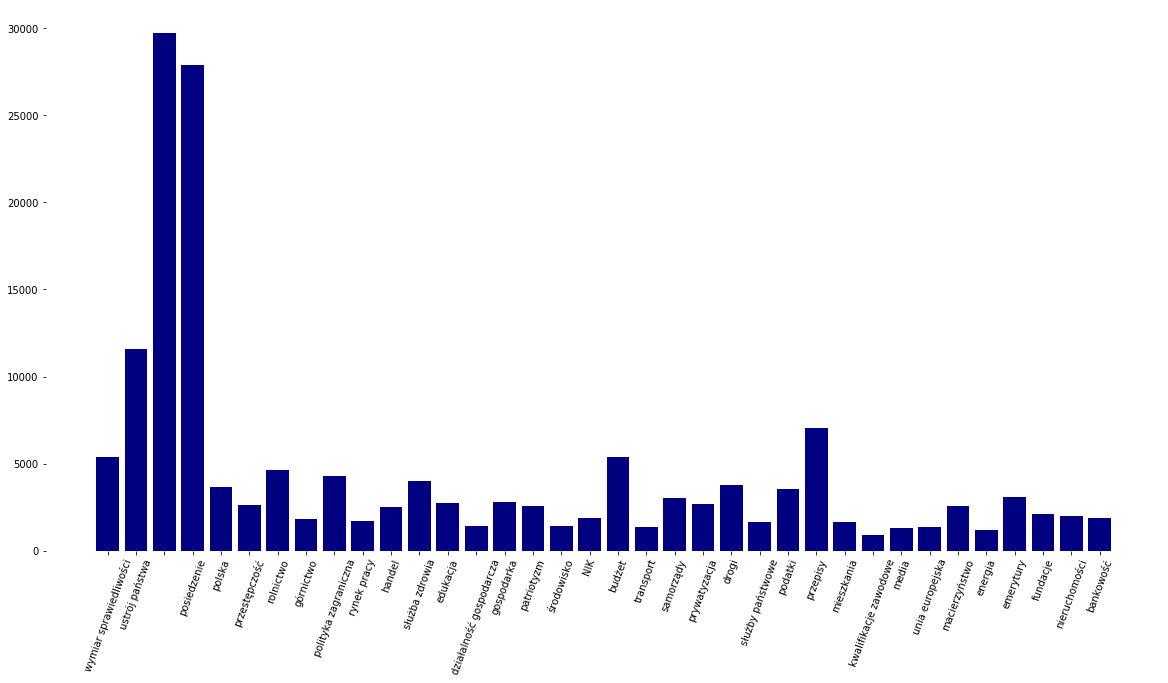

In [42]:
fig = plt.figure(figsize=(20,10))
#color = ["gray"]*len(l_rank.Popularity)
#color[-2]='blue'
bars = plt.bar(list(a.keys()), list(a.values()), align='center', linewidth=0, color='navy')
plt.box(False)
plt.xticks(rotation=70)

## LDA oparte o TF-IDF - paropt


In [7]:
test1, _ = train_test_split(corp,train_size=0.3,random_state=666)  
len(test1)

47663

In [8]:
start = timer()
no_a = [0.2, 0.3, 0.4]
num_t = [20, 30, 40, 50]
p = [3, 5, 7, 10]
res = pd.DataFrame()

for n_a in no_a:
    for n_t in num_t:
        for pas in p:
            
            dictionary = gensim.corpora.Dictionary(test1)
            dictionary.filter_extremes(no_above=n_a, no_below=50)
            BOW = [dictionary.doc2bow(speech) for speech in test1]
            tfidf = models.TfidfModel(BOW)
            corpus_tfidf = tfidf[BOW]

            lda_model = gensim.models.LdaMulticore(corpus_tfidf, id2word=dictionary,num_topics=n_t, passes=pas, workers=2)
            coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=test1, dictionary=dictionary, coherence='c_v')
            coherence_lda = coherence_model_lda.get_coherence()
            print(n_a, n_t, pas, coherence_lda)
            res = res.append([[n_a, n_t, pas, coherence_lda]], ignore_index=True)
end = timer()
print(timedelta(seconds=timer()-start))  

0.2 20 3 0.5177023553460101
0.2 20 5 0.5895460121345366
0.2 20 7 0.5737067524567612
0.2 20 10 0.5754723217973818
0.2 30 3 0.5581397796214363
0.2 30 5 0.551326214563797
0.2 30 7 0.543556590126864
0.2 30 10 0.5244606129766834
0.2 40 3 0.5074905123617048
0.2 40 5 0.5652904819881546
0.2 40 7 0.5727684912552464
0.2 40 10 0.5180694193568716
0.2 50 3 0.528339490676688
0.2 50 5 0.5666798660972369
0.2 50 7 0.5601384377025125
0.2 50 10 0.5275050714755526
0.3 20 3 0.5475008653704487
0.3 20 5 0.5190108726570092
0.3 20 7 0.5586784970911477
0.3 20 10 0.5268707192018911
0.3 30 3 0.5423515479537483
0.3 30 5 0.5481851664430023
0.3 30 7 0.5358938234323322
0.3 30 10 0.556225008858123
0.3 40 3 0.5005335349203082
0.3 40 5 0.5513513733518172
0.3 40 7 0.5482984417543845
0.3 40 10 0.5407680000571565
0.3 50 3 0.552381106152046
0.3 50 5 0.5549751687211717
0.3 50 7 0.5867551672039465
0.3 50 10 0.5609138277994767
0.4 20 3 0.583345411577662
0.4 20 5 0.4971482399206651
0.4 20 7 0.5253627543157569
0.4 20 10 0.577839

#### Model z wybranymi parametrami 0.2, 20, 5

In [9]:
dictionary = gensim.corpora.Dictionary(test1)
dictionary.filter_extremes(no_above=0.2, no_below=50)
BOW = [dictionary.doc2bow(speech) for speech in corp]
tfidf = models.TfidfModel(BOW)
corpus_tfidf = tfidf[BOW]

lda_model = gensim.models.LdaMulticore(corpus_tfidf, id2word=dictionary,num_topics=20, passes=5, workers=2)
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=corp, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(0.2, 20, 5, coherence_lda)

0.2 20 5 0.6402263027031241


In [10]:
funcs.print_topics(lda_model.print_topics(-1))

,0,1,2,3,4,5,6,7,8,9
Topic 0,premier,polak,naprawdę,pis,zrobić,robić,słowo,prawda,sprawiedliwość,szanowny
Topic 1,zwierzę,uchwala_senat,wyrób,produkt,weterynaryjny,wyrób_medyczny,rybołówstwo,żywność,producent,lekarz_weterynaria
Topic 2,inwestycja,las,gmina,droga,program,samorząd,województwo,miasto,powiat,środowisko
Topic 3,pojazd,odpad,morski,kierowca,ruch_drogowy,przewoźnik,samochód,łowiecki,transport_drogowy,transport
Topic 4,uczelnia,naukowy,nauka,uniwersytet,kościół,student,szkolnictwo,instytut,zabytek,akademia
Topic 5,spółka,prywatyzacja,skarb,przedsiębiorstwo,kopalnia,firma,majątek,akcja,bank,zakład
Topic 6,emerytura,emeryt,emerytalny,wiek_emerytalny,waloryzacja,emeryt_rencista,emerytur,wicemarszałek_ryszard,świadczenie,złoty
Topic 7,mieszkanie,mieszkaniowy,spółdzielnia,spółdzielczy,lokal,budownictwo,budowlany,budownictwo_mieszkaniowy,spółdzielnia_mieszkaniowy,lokator
Topic 8,senat,głosować,odrzucić,posiedzenie,zgłosić,klub_parlamentarny,sprawozdanie,uchwała,głosowanie,rozpatrzyć
Topic 9,energia,gospodarka,energetyczny,rozwój,polityka,gospodarczy,rynek,unia_europejski,zagraniczny,gaz


In [13]:
dane['topic_LDA_TF'] = pd.Series()
for i, row in enumerate(lda_model[BOW]):
    dane['topic_LDA_TF'].loc[i] = sorted(row, key=lambda x: (x[1]), reverse=True)[0][0]

C:\Users\Magda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [22]:
topics_2=['polityka','żywność','inwestycje','transport','szkolnictwo wyższe','przedsiębiorstwa','emerytury','mieszkania','posiedzenie','energetyka',
          'przestępczość','rodzina','rolnictwo','przepisy','wojsko','unia europejska','ustrój państwa','edukacja','budżet','służba zdrowia']
dane['opis_LDA_TF'] = dane['topic_LDA_TF'].apply(lambda x: topics_2[int(x)])

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

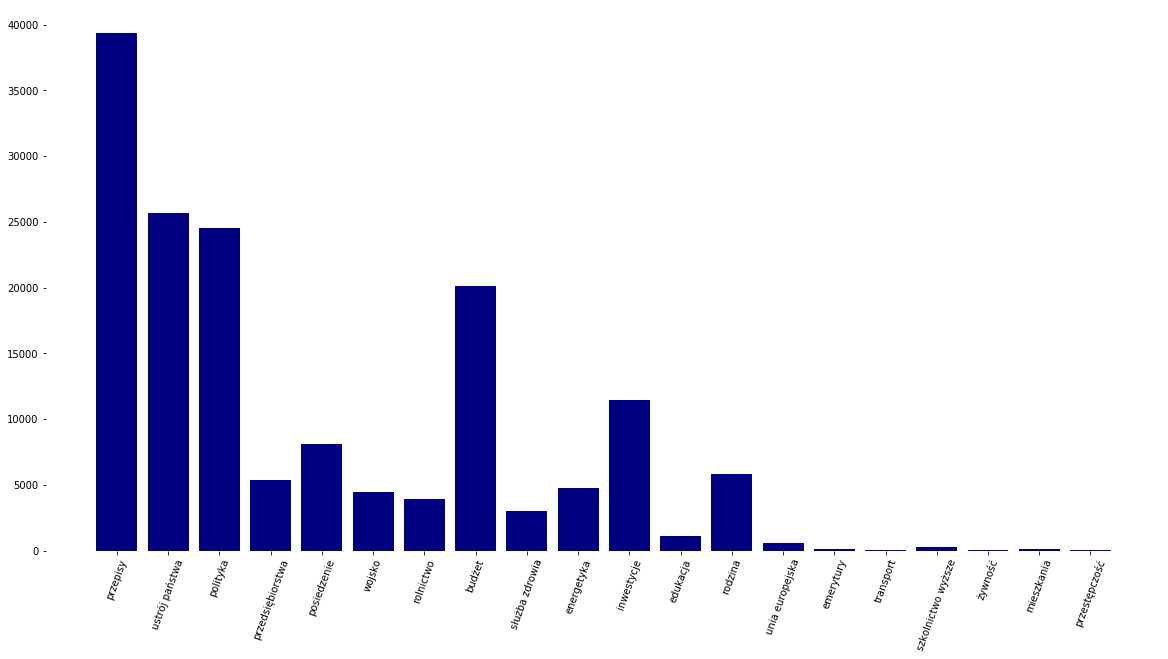

In [23]:
a = Counter(dane['opis_LDA_TF'])
fig = plt.figure(figsize=(20,10))
#color = ["gray"]*len(l_rank.Popularity)
#color[-2]='blue'
bars = plt.bar(list(a.keys()), list(a.values()), align='center', linewidth=0, color='navy')
plt.box(False)
plt.xticks(rotation=70)

In [24]:
pyLDAvis.enable_notebook()

dictionary = gensim.corpora.Dictionary(test1)
dictionary.filter_extremes(no_above=0.2, no_below=50)
BOW = [dictionary.doc2bow(speech) for speech in corp]


In [26]:
vis = pyLDAvis.gensim.prepare(lda_model, BOW, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.148017  0.006328       1        1  23.600283
16    -0.172912 -0.032694       2        1  17.603279
18    -0.159913  0.047498       3        1  12.856401
0     -0.138835 -0.041281       4        1  11.403730
2     -0.128791  0.038470       5        1   5.520203
9     -0.115848  0.065070       6        1   4.385773
5     -0.115681  0.071678       7        1   3.738474
11    -0.126358 -0.041890       8        1   3.630365
8     -0.097417 -0.011096       9        1   3.040502
14    -0.009390 -0.134946      10        1   2.982969
12    -0.084148  0.169008      11        1   2.374916
19    -0.070164 -0.039466      12        1   2.116552
15     0.046198 -0.034436      13        1   1.527363
17     0.058426 -0.195722      14        1   1.476289
10     0.269393 -0.059704      15        1   0.867975
4      0.201294 -0.260394      16        1   0.666590
7      0.186058  0.122006      17        1   0.630724
6      0.128013 -0.028749      18        1   0.557996
3      0.254342  0.118581      19        1   0.539379
1      0.223750  0.241740      20        1   0.480233, topic_info=                 Term          Freq         Total Category  logprob  loglift
1932            senat  58172.000000  58172.000000  Default  30.0000  30.0000
208            rolnik  30121.000000  30121.000000  Default  29.0000  29.0000
155           dziecko  39576.000000  39576.000000  Default  28.0000  28.0000
1793  unia_europejski  39012.000000  39012.000000  Default  27.0000  27.0000
457          głosować  34760.000000  34760.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
77          rolnictwo   1168.858765  26089.248047  Topic20  -4.7565   2.2332
1341           jakość   1042.279175  10264.099609  Topic20  -4.8711   3.0514
3931            towar    938.784180   8190.024414  Topic20  -4.9757   3.1726
881             rynek    960.760803  30482.777344  Topic20  -4.9526   1.8815
2439         handlowy    940.784363   9245.546875  Topic20  -4.9736   3.0535

[1420 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8743      1  0.027223  abonament
8743      2  0.000619  abonament
8743      3  0.000619  abonament
8743      4  0.094660  abonament
8743      5  0.000619  abonament
...     ...       ...        ...
9952     16  0.002444     żłobek
9952     17  0.002444     żłobek
9952     18  0.738226     żłobek
9952     19  0.002444     żłobek
9952     20  0.002444     żłobek

[25880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 17, 19, 1, 3, 10, 6, 12, 9, 15, 13, 20, 16, 18, 11, 5, 8, 7, 4, 2])

In [27]:
dane.head()

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF,opis_LDA_BOW,opis_LDA_TF
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0,wymiar sprawiedliwości,przepisy
1,1,01-02-1992,"Przysłuchując się tej bardzo emocjonalnej, dł...",Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,"[przysłuchiwać, emocjonalny, długo, trwać, deb...",14.0,16.0,ustrój państwa,ustrój państwa
2,2,01-02-1992,"Różne przebyliśmy drogi, żeby tu dzisiaj powi...",Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność,"[różny, przebyć, droga, powiedzieć, swój, ocze...",14.0,0.0,ustrój państwa,polityka
3,3,01-02-1992,"Wszystkim nam bardzo zależy na tym, aby urato...",Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...,"[wszystek, zależeć, uratować, przemysł, stocze...",10.0,5.0,,przedsiębiorstwa
4,4,01-02-1992,Z brzmienia pkt. 1 projektu uchwały odczytuję...,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,"[brzmię, punkt, projekt, uchwała, odczytować, ...",10.0,16.0,,ustrój państwa


In [28]:
dane.to_csv('00_dane/dane_TM.csv', sep='|', encoding='UTF-8', index=False)